<a href="https://colab.research.google.com/github/GiannisAlvanos/Ergasia_bathia_mathisi/blob/main/Ergasia_Bathia_Mathisi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Από τη συλλογή MedMNIST επιλέγω για το OCTMNIST dataset για το project. Το OCTMNIST περιέχει εικόνες 28x28 σε κανάλια grayscale, 4 κλάσεις ( CNV~37.000, DME ~11.000, DRUSEN ~8.600, NORMAL ~40.000 samples) με (train/test/validation splits) = (97,477/10,000/10,832). Υπάρχει ανισορροπία ανάμεσα στις κλάσεις με το μοντέλο να "τείνει" προς τις NORMAL και CNV.
(ΒΑΛΕ ΕΙΚΟΝΕΣ ΜΕ ΠΑΡΑΔΕΙΓΜΑΤΑ ΑΠΟ ΤΟ ΜΝΙΣΤ)


Α) Εδώ ξεκινά η σχεδίαση CNN για ταξινόμηση εικόνων από το dataset OCTMNIST της MedMNIST

In [7]:
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch

# Extract training labels
train_labels = np.array([label for _, label in train_dataset])
train_labels = train_labels.squeeze()

# Count occurrences per class
class_counts = np.bincount(train_labels, minlength=n_classes)
print("Class counts:", class_counts)

# Compute class weights = 1 / frequency
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * n_classes  # normalized
print("Class weights:", class_weights)

# Convert to torch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

Class counts: [33484 10213  7754 46026]
Class weights: [0.42898406 1.40645279 1.85247645 0.3120867 ]


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input: 1 channel, Output: 32 channels
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input: 32 channels, Output: 64 channels
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # Assuming 28x28 input -> 14x14 after 1st pool -> 7x7 after 2nd pool
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7) # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN(num_classes=n_classes).to(DEVICE)

# Print the model architecture
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


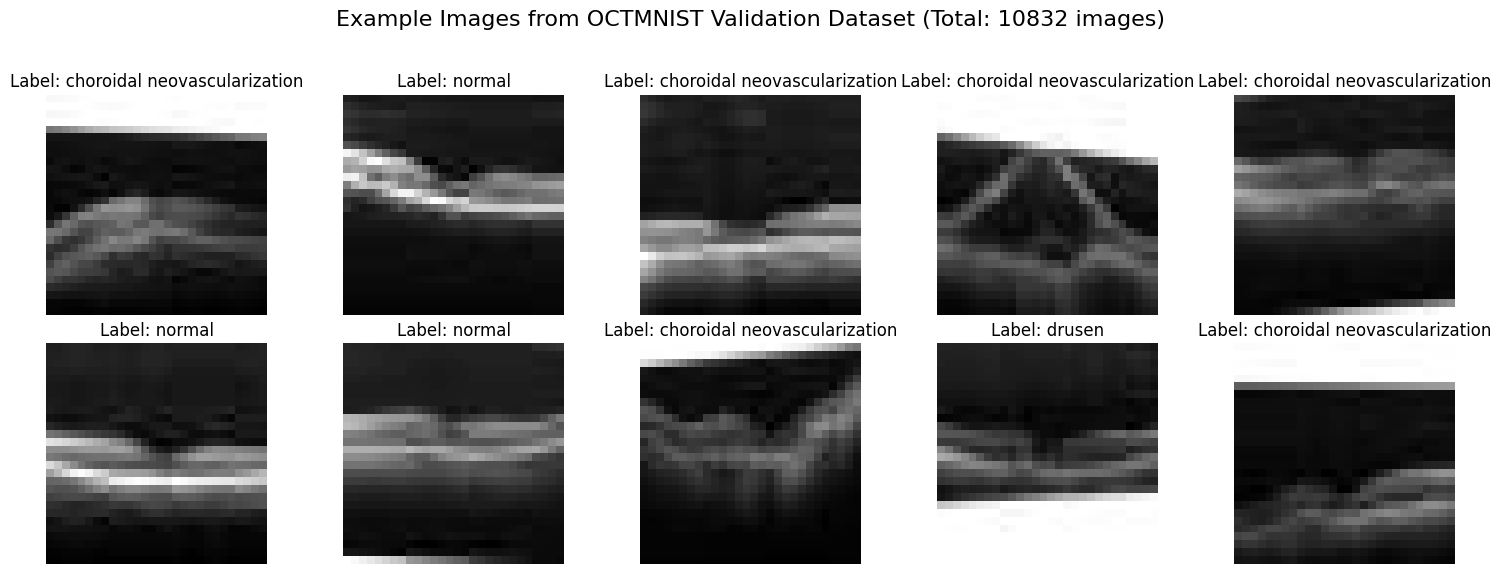

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Get the label names from the info dictionary
label_names = info['label']

# Number of images to display
num_images = 10

# Create a figure to display the images
plt.figure(figsize=(15, 6))

for i in range(num_images):
    # Get a random index from the validation dataset
    idx = np.random.randint(0, len(val_dataset))

    # Get the image and label
    image, label = val_dataset[idx]

    # Convert image tensor to numpy array for displaying (squeeze to remove channel dimension if grayscale)
    image = image.squeeze().numpy()

    # Get the human-readable label name
    label_name = label_names[str(label.item())]

    # Create subplot
    plt.subplot(2, 5, i + 1) # 2 rows, 5 columns
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label_name}")
    plt.axis('off')

plt.suptitle(f"Example Images from OCTMNIST Validation Dataset (Total: {len(val_dataset)} images)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.show()

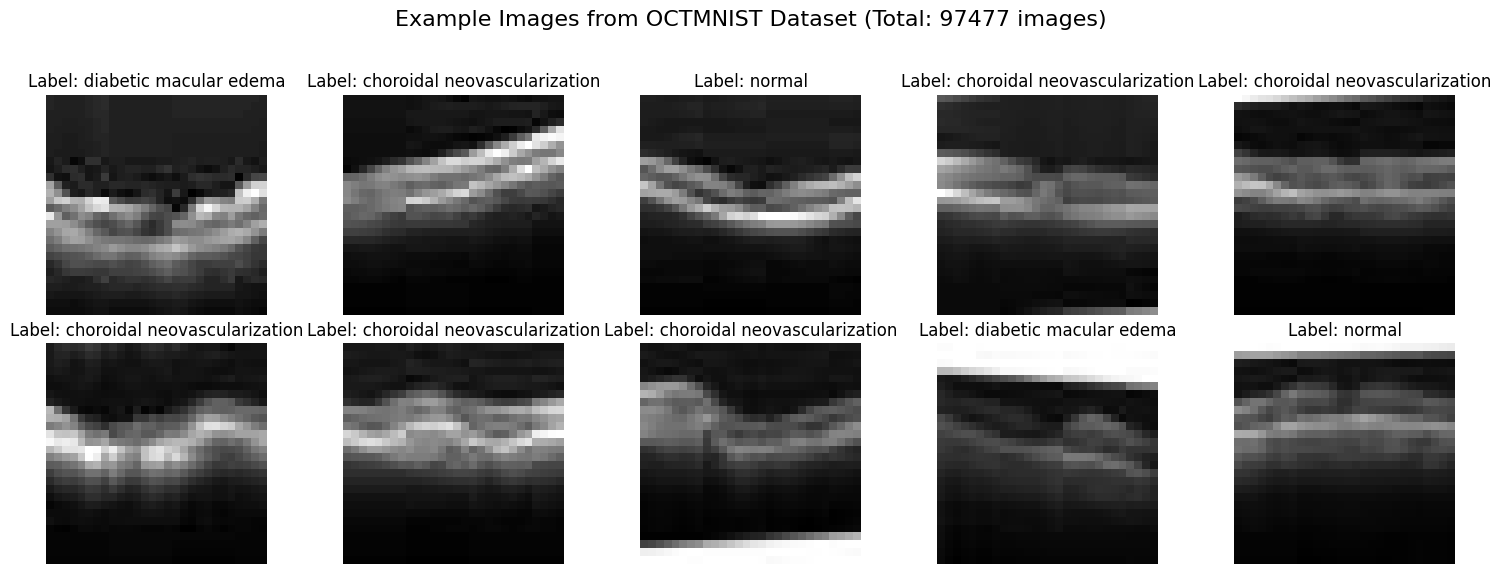

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get the label names from the info dictionary
label_names = info['label']

# Number of images to display
num_images = 10

# Create a figure to display the images
plt.figure(figsize=(15, 6))

for i in range(num_images):
    # Get a random index
    idx = np.random.randint(0, len(train_dataset))

    # Get the image and label
    image, label = train_dataset[idx]

    # Convert image tensor to numpy array for displaying (squeeze to remove channel dimension if grayscale)
    image = image.squeeze().numpy()

    # Get the human-readable label name
    label_name = label_names[str(label.item())]

    # Create subplot
    plt.subplot(2, 5, i + 1) # 2 rows, 5 columns
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label_name}")
    plt.axis('off')

plt.suptitle(f"Example Images from OCTMNIST Dataset (Total: {len(train_dataset)} images)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.show()

In [4]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.1 MB/s eta 0:00:00


In [5]:
import medmnist
from medmnist import INFO, Evaluator
from torchvision import transforms
import torch

print(f"MedMNIST v{medmnist.__version__} is installed.")

MedMNIST v3.0.2 is installed.


In [6]:
# Define transformations
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Define dataset parameters
DATA_FLAG = 'octmnist'
info = INFO[DATA_FLAG]
n_classes = len(info['label'])

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Load datasets
DataClass = getattr(medmnist, info['python_class'])

train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Using device: cpu


100%|██████████| 54.9M/54.9M [00:12<00:00, 4.46MB/s]


Train dataset size: 97477
Validation dataset size: 10832
Test dataset size: 1000


In [14]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [15]:
# Compute sample weights for each image
sample_weights = class_weights[train_labels]

# Create sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Use sampler instead of shuffle=True
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    sampler=sampler
)

# Validation & Test unchanged
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# ============================================# 4) TRAINING + EVALUATION LOOP (UPDATED)# ============================================import torch.optim as optim
import numpy as np # Ensure numpy is imported for np.concatenate

def accuracy(preds, labels):
    preds = preds.argmax(dim=1)
    return (preds == labels).float().mean().item()


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.squeeze().long().to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_acc += accuracy(out, y) * x.size(0)

    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0, 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.squeeze().long().to(device)

            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            total_acc += accuracy(out, y) * x.size(0)

            preds_all.append(out.argmax(dim=1).cpu().numpy())
            labels_all.append(y.cpu().numpy())

    return (
        total_loss / len(loader.dataset),
        total_acc / len(loader.dataset),
        np.concatenate(preds_all),
        np.concatenate(labels_all)
    )


# =====================================================
# TRAINING LOOP — USES THE WEIGHTED LOSS + SAMPLER
# =====================================================
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 30
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val_acc = 0
best_weights = None

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, DEVICE)

    val_loss, val_acc, _, _ = eval_epoch(
        model, val_loader, criterion, DEVICE)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # keep best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = model.state_dict()

# Load best weights
model.load_state_dict(best_weights)
print("\nTraining complete! Best Val Acc =", best_val_acc)

Epoch 1/30 | Train Acc: 0.9281 | Val Acc: 0.8613
Epoch 2/30 | Train Acc: 0.9322 | Val Acc: 0.8075
Epoch 3/30 | Train Acc: 0.9368 | Val Acc: 0.8295
Epoch 4/30 | Train Acc: 0.9402 | Val Acc: 0.8780
Epoch 5/30 | Train Acc: 0.9435 | Val Acc: 0.8273
Epoch 6/30 | Train Acc: 0.9470 | Val Acc: 0.8437
Epoch 7/30 | Train Acc: 0.9500 | Val Acc: 0.8622
Epoch 8/30 | Train Acc: 0.9514 | Val Acc: 0.8546
Epoch 9/30 | Train Acc: 0.9549 | Val Acc: 0.8652
Epoch 10/30 | Train Acc: 0.9568 | Val Acc: 0.8564
Epoch 11/30 | Train Acc: 0.9596 | Val Acc: 0.8576
Epoch 12/30 | Train Acc: 0.9594 | Val Acc: 0.8816


In [ ]:
from collections import Counter
sampled = []

for i in range(2000):
    idx = next(iter(DataLoader(train_dataset, sampler=sampler, batch_size=1)))[1].item()
    sampled.append(idx)

Counter(sampled)


# Task
Create a CNN model for image classification, balancing classes using weighted loss and oversampling, then train and evaluate the model for 30 epochs on the OCTMNIST dataset.

## Import torch.optim

### Subtask:
Add a new cell to explicitly import `torch.optim as optim` to ensure it's loaded in the kernel's global scope.


**Reasoning**:
The previous cell failed because 'optim' was not defined, indicating that `torch.optim` was not explicitly imported. This step will import `torch.optim` as `optim` to resolve the `NameError` and allow the subsequent code to run correctly.



In [18]:
import torch.optim as optim
print("torch.optim imported successfully as optim.")

torch.optim imported successfully as optim.


**Reasoning**:
The previous `NameError` for `optim` has been resolved by explicitly importing `torch.optim`. Now, the training and evaluation loop, which was the next logical step in the overall task, can be re-executed.



In [19]:
import torch.optim as optim
import numpy as np # Ensure numpy is imported for np.concatenate

def accuracy(preds, labels):
    preds = preds.argmax(dim=1)
    return (preds == labels).float().mean().item()


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.squeeze().long().to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_acc += accuracy(out, y) * x.size(0)

    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0, 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.squeeze().long().to(device)

            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            total_acc += accuracy(out, y) * x.size(0)

            preds_all.append(out.argmax(dim=1).cpu().numpy())
            labels_all.append(y.cpu().numpy())

    return (
        total_loss / len(loader.dataset),
        total_acc / len(loader.dataset),
        np.concatenate(preds_all),
        np.concatenate(labels_all)
    )


# =====================================================
# TRAINING LOOP — USES THE WEIGHTED LOSS + SAMPLER
# =====================================================
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 30
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val_acc = 0
best_weights = None

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, DEVICE)

    val_loss, val_acc, _, _ = eval_epoch(
        model, val_loader, criterion, DEVICE)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # keep best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = model.state_dict()

# Load best weights
model.load_state_dict(best_weights)
print("\nTraining complete! Best Val Acc =", best_val_acc)

Epoch 1/30 | Train Acc: 0.5466 | Val Acc: 0.5740
Epoch 2/30 | Train Acc: 0.6963 | Val Acc: 0.5416
Epoch 3/30 | Train Acc: 0.7276 | Val Acc: 0.6090
Epoch 4/30 | Train Acc: 0.7590 | Val Acc: 0.6728
Epoch 5/30 | Train Acc: 0.7898 | Val Acc: 0.6813
Epoch 6/30 | Train Acc: 0.8141 | Val Acc: 0.6160
Epoch 7/30 | Train Acc: 0.8336 | Val Acc: 0.7284
Epoch 8/30 | Train Acc: 0.8494 | Val Acc: 0.7589
Epoch 9/30 | Train Acc: 0.8637 | Val Acc: 0.7807


KeyboardInterrupt: 

# Task
Continue training the CNN model for 30 epochs as defined in the training loop.

## Define Criterion

### Subtask:
Execute cell `urwes8spoeDg` to define the loss function `criterion`.


**Reasoning**:
The user explicitly asked to execute cell `urwes8spoeDg` to define the loss function `criterion`.



In [20]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

**Reasoning**:
The user explicitly asked to execute cell `urwes8spoeDg` to define the loss function `criterion`.



In [21]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

**Reasoning**:
As requested, the code from cell `urwes8spoeDg` is executed to define the `criterion` for the model training.



In [22]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

**Reasoning**:
As requested, the code from cell `urwes8spoeDg` is executed to define the `criterion` for the model training.



In [23]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

**Reasoning**:
The `criterion` has been defined in previous steps, and the main task is to continue training the model for 30 epochs. The training loop previously failed due to a `KeyboardInterrupt`.



In [24]:
import torch.optim as optim
import numpy as np # Ensure numpy is imported for np.concatenate

def accuracy(preds, labels):
    preds = preds.argmax(dim=1)
    return (preds == labels).float().mean().item()


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.squeeze().long().to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_acc += accuracy(out, y) * x.size(0)

    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0, 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.squeeze().long().to(device)

            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            total_acc += accuracy(out, y) * x.size(0)

            preds_all.append(out.argmax(dim=1).cpu().numpy())
            labels_all.append(y.cpu().numpy())

    return (
        total_loss / len(loader.dataset),
        total_acc / len(loader.dataset),
        np.concatenate(preds_all),
        np.concatenate(labels_all)
    )


# =====================================================
# TRAINING LOOP — USES THE WEIGHTED LOSS + SAMPLER
# =====================================================
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 30
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val_acc = 0
best_weights = None

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, DEVICE)

    val_loss, val_acc, _, _ = eval_epoch(
        model, val_loader, criterion, DEVICE)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # keep best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = model.state_dict()

# Load best weights
model.load_state_dict(best_weights)
print("\nTraining complete! Best Val Acc =", best_val_acc)

Epoch 1/30 | Train Acc: 0.8826 | Val Acc: 0.7768
Epoch 2/30 | Train Acc: 0.8952 | Val Acc: 0.8039
Epoch 3/30 | Train Acc: 0.9024 | Val Acc: 0.8423
Epoch 4/30 | Train Acc: 0.9122 | Val Acc: 0.8151
Epoch 5/30 | Train Acc: 0.9192 | Val Acc: 0.8056


KeyboardInterrupt: 

# Task
Executing cell `3B97YWX7ogR1` to define data loaders.

## Define Data Loaders

### Subtask:
Execute cell `3B97YWX7ogR1` to define the data loaders `train_loader`, `val_loader`, and `test_loader`.


**Reasoning**:
The subtask explicitly asks to execute cell `3B97YWX7ogR1` to define the data loaders. This code block will initialize `train_loader`, `val_loader`, and `test_loader`.



In [ ]:
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch

# Extract training labels
train_labels = np.array([label for _, label in train_dataset])
train_labels = train_labels.squeeze()

# Count occurrences per class
class_counts = np.bincount(train_labels, minlength=n_classes)
print("Class counts:", class_counts)

# Compute class weights = 1 / frequency
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * n_classes  # normalized
print("Class weights:", class_weights)

# Convert to torch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

# Compute sample weights for each image
sample_weights = class_weights[train_labels]

# Create sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Use sampler instead of shuffle=True
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    sampler=sampler
)

# Validation & Test unchanged
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)